# 🏴‍☠️ Pirate Pain Classification Challenge

> ⚓ *"Even pirates feel pain — let's teach the model to feel it too."*

---

## 📚 Table of Contents
0. [README](#readme)  
1. [Setup & Configuration](#setup)  
2. [Data Loading](#data-loading)  
3. [Import Libraries](#import-libraries)  
4. [Data Preprocessing](#data-preprocessing)  
5. [Sequence Building](#sequence-building)  
6. [DataLoaders](#dataloaders)  
7. [Model Architecture](#model-architecture)  
8. [Network Hyperparameters](#hyperparameters)  
9. [Training Functions](#training-functions)  
10. [Model Training](#model-training)  
11. [Evaluation & Metrics](#evaluation)  
12. [Model Loading & Final Testing](#model-loading)  
13. [Competition Submission](#submission)

---

### ⚙️ Quick Configuration Map

> 🧭 *"If ye seek to tweak the code, here be where to look!"*

- 🧺 **Batch Size:** → [DataLoaders](#dataloaders)  
- ⚗️ **Hyperparameters:** → [Network Hyperparameters](#hyperparameters)  
- 🪞 **Window Size & Stride:** → [Sequence Building](#sequence-building)  
- ⚙️ **Model Type:** → [Setup & Configuration](#setup)  

---



---

### 💰 Treasure Storage — Models & Submissions
> 🏴‍☠️ *"A wise pirate always knows where his treasure be buried — guard yer models and submissions well!"*

- 💾 **Model & Submission Save/Load Path:** → [Setup & Configuration](#setup)  
  - 🗂️ Models be saved in a **`models/`** folder with the name:
    **`experiment_name_dd-mm-HH-MM.pt`** (day-month-hour-minute).
  - 📜 Submissions be saved in a **`submissions/`** folder with the filename format:  
    **`experiment_name_dd-mm-HH-MM.csv`** .
  - 🔡 All related model parameters are saved in **`models/`** folder with the  name **`experiment_name_dd-mm-HH-MM_config.json`** .

  
  *❗The experiment name is set as **`RnnType_Bi_dd-mm-HH-MM`** or **`RnnType_dd-mm-HH-MM`** depending on if it is bidirectional or not*
---






<a id="readme"></a>
## 0. Info



This section lists all the main parameters that can be modified to control data loading, model behavior, and training.

---

### 📁 File Paths
| Variable | Description | Default Value |
|-----------|--------------|----------------|
| `TRAIN_DATA_PATH` | Training features | `'pirate_pain_train.csv'` |
| `TRAIN_LABELS_PATH` | Training labels | `'pirate_pain_train_labels.csv'` |
| `TEST_DATA_PATH` | Test set for inference | `'pirate_pain_test.csv'` *(optional)* |
| `MODEL_SAVE_PATH` | Output model file | `'pirate_model.pt'` |
| `RESULTS_FILE` | CSV for predictions | `'results_<date-time>.csv'` |

---

### 🧠 Model & Architecture
| Parameter | Description | Typical Values |
|------------|--------------|----------------|
| `model_type` | Choose model class | `'RNN'`, `'LSTM'`, `'GRU'`, `'ANN'` |
| `input_size` | Number of features per time step | *auto-detected from data* |
| `hidden_size` | Hidden layer size | `64`, `128`, `256` |
| `num_layers` | Number of RNN layers | `1-4` |
| `dropout` | Dropout probability | `0.2–0.5` |
| `num_classes` | Output classes (pain levels) | *from label set* |

---

### 🏋️ Training Hyperparameters
| Parameter | Description | Default / Range |
|------------|--------------|-----------------|
| `batch_size` | Samples per batch | `512/2^n` |
| `learning_rate` | Optimizer learning rate | `1e-3` |
| `num_epochs` | Training iterations | `500` |
| `optimizer` | Optimization algorithm | `'AdamW'` |
| `criterion` | Loss function | `CrossEntropyLoss()` |
| `seed` | Random seed for reproducibility | `42` |

---

### 📤 Inference
| Parameter | Description |
|------------|--------------|
| `LOAD_MODEL_PATH` | Path to pretrained `.pt` model (optional) |
| `save_results` | Whether to write output CSV | `True` |

---

> 💡 *Tip:* Adjust hyperparameters in the “Configuration” or “Training Setup” cell before running the notebook.


<a id="setup"></a>
## 1. Setup & Configuration

*Optional: Connect to Google Drive (for Colab users)*

In [51]:
# from google.colab import drive
# drive.mount("/gdrive")
# current_dir = "/gdrive/My\\ Drive/AN2DL Challenge 1"
# %cd $current_dir

*Set Model Type*

In [52]:
RNN_TYPE = 'LSTM'            # 'RNN', 'LSTM', or 'GRU'
BIDIRECTIONAL = True        # True / False

*Set Model Save Name*

In [53]:
from datetime import datetime

# Get current date and time for submission filename
current_datetime = datetime.now().strftime("%d-%m-%H-%M")

if BIDIRECTIONAL:
    EXPERIMENT_NAME = f"{RNN_TYPE}_bi_{current_datetime}"
else:
    EXPERIMENT_NAME = f"{RNN_TYPE}_{current_datetime}"

SUBMISSION_FILENAME = f"{EXPERIMENT_NAME}_{current_datetime}.csv"
print(f"Experiment name: {EXPERIMENT_NAME}")
print(f"Submission filename: {SUBMISSION_FILENAME}")

Experiment name: LSTM_bi_10-11-10-33
Submission filename: LSTM_bi_10-11-10-33_10-11-10-33.csv


<a id="data-loading"></a>
## 2. Data Loading

Load training and test datasets from CSV files.

In [54]:
import pandas as pd

X_train = pd.read_csv('an2dl2526c1/pirate_pain_train.csv')
y_train = pd.read_csv('an2dl2526c1/pirate_pain_train_labels.csv')

<a id="import-libraries"></a>
## 3. Import Libraries

Set random seeds for reproducibility and import all necessary packages.

In [55]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader

# Directory configuration
logs_dir = "tensorboard"
models_dir = "models"



# Model save/load paths
MODEL_SAVE_PATH = f"{models_dir}/{EXPERIMENT_NAME}_model.pt"
MODEL_LOAD_PATH = f"{models_dir}/{EXPERIMENT_NAME}_model.pt"

!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p {models_dir}

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
from datetime import datetime
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


'pkill' is not recognized as an internal or external command,
operable program or batch file.


PyTorch version: 2.10.0.dev20251109+cu128
Device: cuda


A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file models already exists.
Error occurred while processing: models.


<a id="data-preprocessing"></a>
## 4. Data Preprocessing

Explore data, split into train/val/test sets, normalize features, and encode labels.

In [56]:
# Print the shape of the dataset
print(f"Dataset shape: {X_train.shape}")

# Display the first few rows of the dataset
X_train.head(10)

Dataset shape: (105760, 40)


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
0,0,0,2,0,2,1,two,two,two,1.094705,...,3.499558e-06,1.945042e-06,3.999558e-06,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815,0.5
1,0,1,2,2,2,2,two,two,two,1.135183,...,3.976952e-07,6.765107e-07,6.019627e-06,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716,0.5
2,0,2,2,0,2,2,two,two,two,1.080745,...,1.533820e-07,1.698525e-07,1.446051e-06,2.424536e-06,0.000003,0.016225,0.008110,0.024097,0.023105,0.5
3,0,3,2,2,2,2,two,two,two,0.938017,...,1.006865e-05,5.511079e-07,1.847597e-06,5.432416e-08,0.000000,0.011832,0.007450,0.028613,0.024648,0.5
4,0,4,2,2,2,2,two,two,two,1.090185,...,4.437266e-06,1.735459e-07,1.552722e-06,5.825366e-08,0.000007,0.005360,0.002532,0.033026,0.025328,0.5
5,0,5,2,0,2,1,two,two,two,1.146031,...,1.073167e-06,1.753837e-07,2.957340e-07,6.217311e-08,0.000007,0.006150,0.006444,0.033101,0.023767,0.5
6,0,6,2,1,2,1,two,two,two,1.025870,...,1.074800e-06,1.772156e-07,1.976558e-06,1.576086e-06,0.000005,0.006495,0.006421,0.031804,0.019056,0.5
7,0,7,2,2,2,2,two,two,two,1.038597,...,8.829074e-07,1.790415e-07,2.210562e-06,1.485741e-06,0.000000,0.015998,0.005397,0.035552,0.015732,0.5
8,0,8,2,2,0,1,two,two,two,0.984251,...,1.621055e-06,1.165161e-06,3.030164e-07,5.416678e-07,0.000000,0.020539,0.008517,0.008635,0.015257,0.5
9,0,9,0,2,2,2,two,two,two,1.054999,...,1.609114e-06,3.959558e-06,2.017157e-06,1.154349e-06,0.000007,0.007682,0.021383,0.034006,0.028966,0.5


### 4.1 Data Exploration

In [57]:
# Merge features and labels
data = X_train.merge(y_train, on='sample_index')

# Create a mapping dictionary to convert categorical labels to numerical values
map_dict = {'none': 0, 'one': 1, 'two': 2}
data['n_legs'] = data['n_legs'].map(map_dict)
data['n_hands'] = data['n_hands'].map(map_dict)
data['n_eyes'] = data['n_eyes'].map(map_dict)


<a id="sequence-building"></a>
## 5. Sequence Building

Convert variable-length time-series into fixed-size windows for RNN input.

In [58]:

# Define window and stride boolean variable -> if True, during training we will visit more time the same pirate with overlapping windows
# if False, each pirate will be visited only once during training
one_pirate_window = True

In [59]:
if one_pirate_window:
    # Define the window size
    WINDOW_SIZE = 40 # before: 80

    # Stride size
    STRIDE = 5
else:
    # Define the window size -> select an higher window size in order to get more pirates
    WINDOW_SIZE = 160

    # Stride size
    STRIDE = 160

### 5.1 Window & Stride Configuration

In [60]:
"""
  GENERAL COMMENTS:
  in this function we are restricting for each user data the number of samples of recorded data to a constant
  value (window size), since every user data could be composed by different numbers of timestep. Therefore we are
  "normalizing" the timesteps of a constant window size. Additionally is also defined a stride variable, which if is equal to
  the window size, then we are not taking overlapping timestamp samples, instead if stride < window, we are letting some samples
  to overlap in such a way that the RNN or other kind of NN architecture will analyze better the context.
"""

# Define a function to build sequences from the dataset
def build_sequences(df, window=200, stride=200):
    # Sanity check to ensure the window is divisible by the stride
    assert window % stride == 0 # checks if the window size is divisible by the stride

    # Initialise lists to store sequences and their corresponding labels
    dataset = []
    labels = []

    # Iterate over unique IDs in the DataFrame
    for id in df['sample_index'].unique():

        # Extract pirate sample index data for the current sample index
        columns = [col for col in df.columns if col not in ['sample_index', 'label', 'time']]

        temp = df[df['sample_index'] == id][columns].values

        # Retrieve the label for the current pirate
        label = df[df['sample_index'] == id]['label'].values[0]

        # Calculate padding length to ensure full windows
        padding_len = window - len(temp) % window

        # Create zero padding and concatenate with the data
        padding = np.zeros((padding_len, len(columns)), dtype='float32')
        temp = np.concatenate((temp, padding))

        # Build feature windows and associate them with labels
        idx = 0
        while idx + window <= len(temp):
            dataset.append(temp[idx:idx + window])
            labels.append(label)
            idx += stride

    # Convert lists to numpy arrays for further processing
    dataset = np.array(dataset)
    labels = np.array(labels)

    return dataset, labels

<a id="dataloaders"></a>
## 6. DataLoaders

Create PyTorch DataLoaders for efficient batching and parallel loading.

In [61]:
# Define the batch size, which is the number of samples in each batch
BATCH_SIZE = 1024 # we can change it depending on the GPU RAM available (by default 512)

In [62]:
def make_loader(ds, batch_size, shuffle, drop_last):
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
    )

In [63]:
def recurrent_summary(model, input_size):
    """
    Custom summary function that emulates torchinfo's output while correctly
    counting parameters for RNN/GRU/LSTM layers.

    This function is designed for models whose direct children are
    nn.Linear, nn.RNN, nn.GRU, or nn.LSTM layers.

    Args:
        model (nn.Module): The model to analyze.
        input_size (tuple): Shape of the input tensor (e.g., (seq_len, features)).
    """

    # Dictionary to store output shapes captured by forward hooks
    output_shapes = {}
    # List to track hook handles for later removal
    hooks = []

    def get_hook(name):
        """Factory function to create a forward hook for a specific module."""
        def hook(module, input, output):
            # Handle RNN layer outputs (returns a tuple)
            if isinstance(output, tuple):
                # output[0]: all hidden states with shape (batch, seq_len, hidden*directions)
                shape1 = list(output[0].shape)
                shape1[0] = -1  # Replace batch dimension with -1

                # output[1]: final hidden state h_n (or tuple (h_n, c_n) for LSTM)
                if isinstance(output[1], tuple):  # LSTM case: (h_n, c_n)
                    shape2 = list(output[1][0].shape)  # Extract h_n only
                else:  # RNN/GRU case: h_n only
                    shape2 = list(output[1].shape)

                # Replace batch dimension (middle position) with -1
                shape2[1] = -1

                output_shapes[name] = f"[{shape1}, {shape2}]"

            # Handle standard layer outputs (e.g., Linear)
            else:
                shape = list(output.shape)
                shape[0] = -1  # Replace batch dimension with -1
                output_shapes[name] = f"{shape}"
        return hook

    # 1. Determine the device where model parameters reside
    try:
        device = next(model.parameters()).device
    except StopIteration:
        device = torch.device("cpu")  # Fallback for models without parameters

    # 2. Create a dummy input tensor with batch_size=1
    dummy_input = torch.randn(1, *input_size).to(device)

    # 3. Register forward hooks on target layers
    # Iterate through direct children of the model (e.g., self.rnn, self.classifier)
    for name, module in model.named_children():
        if isinstance(module, (nn.Linear, nn.RNN, nn.GRU, nn.LSTM)):
            # Register the hook and store its handle for cleanup
            hook_handle = module.register_forward_hook(get_hook(name))
            hooks.append(hook_handle)

    # 4. Execute a dummy forward pass in evaluation mode
    model.eval()
    with torch.no_grad():
        try:
            model(dummy_input)
        except Exception as e:
            print(f"Error during dummy forward pass: {e}")
            # Clean up hooks even if an error occurs
            for h in hooks:
                h.remove()
            return

    # 5. Remove all registered hooks
    for h in hooks:
        h.remove()

    # --- 6. Print the summary table ---

    print("-" * 79)
    # Column headers
    print(f"{'Layer (type)':<25} {'Output Shape':<28} {'Param #':<18}")
    print("=" * 79)

    total_params = 0
    total_trainable_params = 0

    # Iterate through modules again to collect and display parameter information
    for name, module in model.named_children():
        if name in output_shapes:
            # Count total and trainable parameters for this module
            module_params = sum(p.numel() for p in module.parameters())
            trainable_params = sum(p.numel() for p in module.parameters() if p.requires_grad)

            total_params += module_params
            total_trainable_params += trainable_params

            # Format strings for display
            layer_name = f"{name} ({type(module).__name__})"
            output_shape_str = str(output_shapes[name])
            params_str = f"{trainable_params:,}"

            print(f"{layer_name:<25} {output_shape_str:<28} {params_str:<15}")

    print("=" * 79)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {total_trainable_params:,}")
    print(f"Non-trainable params: {total_params - total_trainable_params:,}")
    print("-" * 79)

<a id="hyperparameters"></a>
## 8. Network Hyperparameters

Configure training settings, architecture parameters, and regularization.

In [64]:
 # Training configuration
LEARNING_RATE = 1e-3
EPOCHS = 500

# Architecture
HIDDEN_LAYERS = 2        # Hidden layers
HIDDEN_SIZE = 64        # Neurons per layer -> prev hidden size = 128

# Regularisation
DROPOUT_RATE = 0.3       # Dropout probability

# For now disable weight decay
L1_LAMBDA = 1e-4          # L1 penalty
L2_LAMBDA = 1e-3          # L2 penalty
K = 5
PATIENCE_KFOLD = 50
VERBOSE = 10

# Set up loss function and optimizer
#weights = torch.tensor([1.0, 1.5, 1.5]).to(device)
criterion = nn.CrossEntropyLoss()

In [65]:
# Initialize best model tracking variables
best_model = None
best_performance = float('-inf')

<a id="model-architecture"></a>
## 7. Model Architecture

Custom RNN/LSTM/GRU classifier with configurable bidirectionality and dropout.

### 7.1 Recurrent Classifier Class

In [66]:
class RecurrentClassifier(nn.Module):
    """
    Generic RNN classifier (RNN, LSTM, GRU).
    Uses the last hidden state for classification.
    """
    def __init__(
            self,
            input_size,
            hidden_size,
            num_layers,
            num_classes,
            rnn_type= RNN_TYPE,        # 'RNN', 'LSTM', or 'GRU'
            bidirectional=BIDIRECTIONAL,
            dropout_rate=0.2
            ):
        super().__init__()

        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional

        # Map string name to PyTorch RNN class
        rnn_map = {
            'RNN': nn.RNN,
            'LSTM': nn.LSTM,
            'GRU': nn.GRU
        }

        if rnn_type not in rnn_map:
            raise ValueError("rnn_type must be 'RNN', 'LSTM', or 'GRU'")

        rnn_module = rnn_map[rnn_type]

        # Dropout is only applied between layers (if num_layers > 1)
        dropout_val = dropout_rate if num_layers > 1 else 0 # dropout between RNN layers, applied for regularization

        # Create the recurrent layer
        self.rnn = rnn_module(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,       # Input shape: (batch, seq_len, features)
            bidirectional=bidirectional, # We are defining a bidirectional RNN since we want to extract also the future contextual information for making better predictions
            dropout=dropout_val
        )

        # Calculate input size for the final classifier
        if self.bidirectional:
            classifier_input_size = hidden_size * 2 # Concat fwd + bwd
        else:
            classifier_input_size = hidden_size

        # Final classification layer
        self.classifier = nn.Linear(classifier_input_size, num_classes) # output layer for classifying

    def forward(self, x):
        """
        x shape: (batch_size, seq_length, input_size)
        """

        # rnn_out shape: (batch_size, seq_len, hidden_size * num_directions)
        rnn_out, hidden = self.rnn(x) # feeds the input sequence into the RNN layer
        # rnn_out -> contains the hidden state output for every timestep

        # LSTM returns (h_n, c_n), we only need h_n
        if self.rnn_type == 'LSTM':
            hidden = hidden[0]  # final hidden state of the last timestep

        # hidden shape: (num_layers * num_directions, batch_size, hidden_size)

        if self.bidirectional:
            # Reshape to (num_layers, 2, batch_size, hidden_size)
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)

            # Concat last fwd (hidden[-1, 0, ...]) and bwd (hidden[-1, 1, ...])
            # Final shape: (batch_size, hidden_size * 2)
            hidden_to_classify = torch.cat([hidden[-1, 0, :, :], hidden[-1, 1, :, :]], dim=1)
        else:
            # Take the last layer's hidden state
            # Final shape: (batch_size, hidden_size)
            hidden_to_classify = hidden[-1]

        # Get logits
        logits = self.classifier(hidden_to_classify)
        return logits

<a id="training-functions"></a>
## 9. Training Functions

Helper functions for training, validation, logging, and early stopping.

In [67]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm


        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1

### 9.1 Validate One Epoch Function

In [68]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_accuracy

### 9.2 Validate One Epoch Function

In [69]:
def log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, val_loss, val_f1, model):
    """
    Log training metrics and model parameters to TensorBoard for visualization.

    Args:
        writer (SummaryWriter): TensorBoard SummaryWriter object for logging
        epoch (int): Current epoch number (used as x-axis in TensorBoard plots)
        train_loss (float): Training loss for this epoch
        train_f1 (float): Training f1 score for this epoch
        val_loss (float): Validation loss for this epoch
        val_f1 (float): Validation f1 score for this epoch
        model (nn.Module): The neural network model (for logging weights/gradients)

    Note:
        This function logs scalar metrics (loss/f1 score) and histograms of model
        parameters and gradients, which helps monitor training progress and detect
        issues like vanishing/exploding gradients.
    """
    # Log scalar metrics
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('F1/Training', train_f1, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)

    # Log model parameters and gradients
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Check if the tensor is not empty before adding a histogram
            if param.numel() > 0:
                writer.add_histogram(f'{name}/weights', param.data, epoch)
            if param.grad is not None:
                # Check if the gradient tensor is not empty before adding a histogram
                if param.grad.numel() > 0:
                    if param.grad is not None and torch.isfinite(param.grad).all():
                        writer.add_histogram(f'{name}/gradients', param.grad.data, epoch)

### 9.3 TensorBoard Logging Function

In [70]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name=""):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # Write metrics to TensorBoard for visualization
        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_loss, train_f1, val_loss, val_f1, model
            )

        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), f"{models_dir}/{experiment_name}_model.pt")
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load(f"{models_dir}/{experiment_name}_model.pt"))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), f"{models_dir}/{experiment_name}_model.pt")

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

## K-fold Cross-Validation

In [2]:
# Modified version of k_shuffle_split_cross_validation_round_rnn that returns models
from sklearn.model_selection import train_test_split
import copy

def k_shuffle_split_cross_validation_round_rnn_with_models(df, epochs, criterion, device,
                            k, n_val_users, n_test_users, batch_size, hidden_layers, hidden_size, learning_rate, dropout_rate,
                            window_size, stride, rnn_type, bidirectional,
                            l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
                            restore_best_weights=True, writer=None, verbose=10, seed=42, experiment_name=""):
    """
    Perform K-fold shuffle split cross-validation with user-based splitting for time series data.
    Modified to return trained models.

    Returns:
        fold_losses: Dict with validation losses for each split
        fold_metrics: Dict with validation F1 scores for each split
        best_scores: Dict with best F1 score for each split plus mean and std
        trained_models: Dict with the best trained model from each split
        model_performances: Dict with detailed performance metrics for each model
    """

    # Initialise containers for results across all splits
    fold_losses = {}
    fold_metrics = {}
    best_scores = {}
    trained_models = {}  # New: store trained models
    model_performances = {}  # New: store model performance details

    # Get the global num_classes
    global_num_classes = 3 # Based on 'no_pain', 'low_pain', 'high_pain'

    # Iterate through K random splits
    for split_idx in range(k):

        if verbose > 0:
            print(f"Split {split_idx+1}/{k}")

        # --- Step 1: Compute each user's dominant label
        user_labels = (
            df.groupby('sample_index')['label']
            .agg(lambda x: x.value_counts().index[0])
            .reset_index()
        )

        # Split users stratified by their dominant label
        train_users, temp_users = train_test_split(
            user_labels['sample_index'],
            test_size=(n_val_users + n_test_users) / len(user_labels),
            stratify=user_labels['label'],
            random_state=seed + split_idx
        )

        temp_labels = user_labels[user_labels['sample_index'].isin(temp_users)]
        val_users, test_users = train_test_split(
            temp_labels['sample_index'],
            test_size=n_test_users / (n_val_users + n_test_users),
            stratify=temp_labels['label'],
            random_state=seed + split_idx
        )

        # Filter dataframes
        df_train = df[df['sample_index'].isin(train_users)]
        df_val = df[df['sample_index'].isin(val_users)]
        df_test = df[df['sample_index'].isin(test_users)]

        # Map labels
        label_mapping = {'no_pain': 0, 'low_pain': 1, 'high_pain': 2}
        df_train['label'] = df_train['label'].map(label_mapping)
        df_val['label'] = df_val['label'].map(label_mapping)
        df_test['label'] = df_test['label'].map(label_mapping)

        if verbose > 0:
            print(f"  Training set shape: {df_train.shape}")
            print(f"  Validation set shape: {df_val.shape}")
            print(f"  Test set shape: {df_test.shape}")

        # Normalize features
        scale_columns = [col for col in df.columns
                        if (col.startswith('joint_') or col.startswith('pain_survey')) and not col.startswith('joint_30')]

        mins_train = df_train[scale_columns].min()
        maxs_train = df_train[scale_columns].max()

        for column in scale_columns:
            df_train[column] = (df_train[column] - mins_train[column]) / (maxs_train[column] - mins_train[column])
            df_val[column] = (df_val[column] - mins_train[column]) / (maxs_train[column] - mins_train[column])
            df_test[column] = (df_test[column] - mins_train[column]) / (maxs_train[column] - mins_train[column])

        # Build sequences
        X_train_fold, y_train_fold = build_sequences(df_train, window=window_size, stride=stride)
        X_val_fold, y_val_fold = build_sequences(df_val, window=window_size, stride=stride)
        X_test_fold, y_test_fold = build_sequences(df_test, window=window_size, stride=stride)

        # Convert and clean data
        X_train_fold = np.nan_to_num(X_train_fold.astype('float32'))
        X_val_fold = np.nan_to_num(X_val_fold.astype('float32'))
        X_test_fold = np.nan_to_num(X_test_fold.astype('float32'))

        if verbose > 0:
            print(f"  Training sequences shape: {X_train_fold.shape}")
            print(f"  Validation sequences shape: {X_val_fold.shape}")
            print(f"  Test sequences shape: {X_test_fold.shape}")

        # Initialize model
        in_features_model = X_train_fold.shape[-1]
        model = RecurrentClassifier(
            input_size=in_features_model,
            hidden_size=hidden_size,
            num_layers=hidden_layers,
            num_classes=global_num_classes,
            dropout_rate=dropout_rate,
            bidirectional=bidirectional,
            rnn_type=rnn_type
        ).to(device)

        # Create data loaders
        train_ds = TensorDataset(torch.from_numpy(X_train_fold), torch.from_numpy(y_train_fold))
        val_ds = TensorDataset(torch.from_numpy(X_val_fold), torch.from_numpy(y_val_fold))
        test_ds = TensorDataset(torch.from_numpy(X_test_fold), torch.from_numpy(y_test_fold))

        train_loader = make_loader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
        val_loader = make_loader(val_ds, batch_size=batch_size, shuffle=False, drop_last=False)
        test_loader = make_loader(test_ds, batch_size=batch_size, shuffle=False, drop_last=False)

        # Define optimizer
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)
        split_scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

        # Create directory for model checkpoints
        os.makedirs(f"models/{experiment_name}", exist_ok=True)

        # Train model
        model, training_history = fit(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=epochs,
            criterion=criterion,
            optimizer=optimizer,
            scaler=split_scaler,
            device=device,
            writer=writer,
            patience=patience,
            verbose=verbose,
            l1_lambda=l1_lambda,
            evaluation_metric=evaluation_metric,
            mode=mode,
            restore_best_weights=restore_best_weights,
            experiment_name=experiment_name+"/split_"+str(split_idx)
        )

        # Store the trained model
        trained_models[f"split_{split_idx}"] = copy.deepcopy(model.state_dict())
        
        # Evaluate model on test set to get performance metrics
        model.eval()
        test_predictions = []
        test_true_labels = []
        
        with torch.no_grad():
            for batch_data, batch_labels in test_loader:
                batch_data = batch_data.to(device)
                batch_labels = batch_labels.to(device)
                
                outputs = model(batch_data)
                predictions = torch.argmax(outputs, dim=1)
                
                test_predictions.extend(predictions.cpu().numpy())
                test_true_labels.extend(batch_labels.cpu().numpy())
        
        # Calculate performance metrics
        test_f1 = f1_score(test_true_labels, test_predictions, average='weighted')
        test_accuracy = accuracy_score(test_true_labels, test_predictions)
        
        model_performances[f"split_{split_idx}"] = {
            'test_f1': test_f1,
            'test_accuracy': test_accuracy,
            'best_val_f1': max(training_history['val_f1']),
            'training_history': training_history
        }

        # Store results for this split
        fold_losses[f"split_{split_idx}"] = training_history['val_loss']
        fold_metrics[f"split_{split_idx}"] = training_history['val_f1']
        best_scores[f"split_{split_idx}"] = max(training_history['val_f1'])

        if verbose > 0:
            print(f"  Split {split_idx+1} - Best Val F1: {best_scores[f'split_{split_idx}']:.4f}, Test F1: {test_f1:.4f}")

    # Compute mean and standard deviation of best scores across splits
    best_scores["mean"] = np.mean([best_scores[k] for k in best_scores.keys() if k.startswith("split_")])
    best_scores["std"] = np.std([best_scores[k] for k in best_scores.keys() if k.startswith("split_")])

    if verbose > 0:
        print(f"Overall Best Score: {best_scores['mean']:.4f}±{best_scores['std']:.4f}")
        
        # Print summary of all models
        print(f"\nModel Performance Summary:")
        for split_name in sorted([k for k in model_performances.keys()]):
            perf = model_performances[split_name]
            print(f"  {split_name}: Val F1={perf['best_val_f1']:.4f}, Test F1={perf['test_f1']:.4f}, Test Acc={perf['test_accuracy']:.4f}")

    return fold_losses, fold_metrics, best_scores, trained_models, model_performances

In [72]:
# Example: How to use the modified function to extract models
print("Running K-fold cross-validation with model extraction...")
N_VAL_USERS = 100
N_TEST_USERS = 5

# Execute K-fold cross-validation that returns models
losses, metrics, best_scores, trained_models, model_performances = k_shuffle_split_cross_validation_round_rnn_with_models(
    df=data,
    epochs=EPOCHS,
    criterion=criterion,
    device=device,
    k=K,
    batch_size=BATCH_SIZE,
    hidden_layers=HIDDEN_LAYERS,
    hidden_size=HIDDEN_SIZE,
    learning_rate=LEARNING_RATE,
    dropout_rate=DROPOUT_RATE,
    l1_lambda=L1_LAMBDA,
    l2_lambda=L2_LAMBDA,
    verbose=VERBOSE,
    patience=PATIENCE_KFOLD,
    seed=SEED,
    experiment_name="LSTM_with_models",
    n_val_users=N_VAL_USERS,
    n_test_users=N_TEST_USERS,
    window_size=WINDOW_SIZE,
    stride=STRIDE,
    rnn_type=RNN_TYPE,
    bidirectional=BIDIRECTIONAL
)

Running K-fold cross-validation with model extraction...
Split 1/5
  Training set shape: (88960, 41)
  Validation set shape: (16000, 41)
  Test set shape: (800, 41)
  Training sequences shape: (18348, 40, 38)
  Validation sequences shape: (3300, 40, 38)
  Test sequences shape: (165, 40, 38)
Training 500 epochs...
  Training sequences shape: (18348, 40, 38)
  Validation sequences shape: (3300, 40, 38)
  Test sequences shape: (165, 40, 38)
Training 500 epochs...
Epoch   1/500 | Train: Loss=1.6936, F1 Score=0.6718 | Val: Loss=0.7193, F1 Score=0.6699
Epoch   1/500 | Train: Loss=1.6936, F1 Score=0.6718 | Val: Loss=0.7193, F1 Score=0.6699
Epoch  10/500 | Train: Loss=0.6964, F1 Score=0.7173 | Val: Loss=0.5652, F1 Score=0.7116
Epoch  10/500 | Train: Loss=0.6964, F1 Score=0.7173 | Val: Loss=0.5652, F1 Score=0.7116
Epoch  20/500 | Train: Loss=0.4644, F1 Score=0.8197 | Val: Loss=0.3964, F1 Score=0.8295
Epoch  20/500 | Train: Loss=0.4644, F1 Score=0.8197 | Val: Loss=0.3964, F1 Score=0.8295
Epoch  

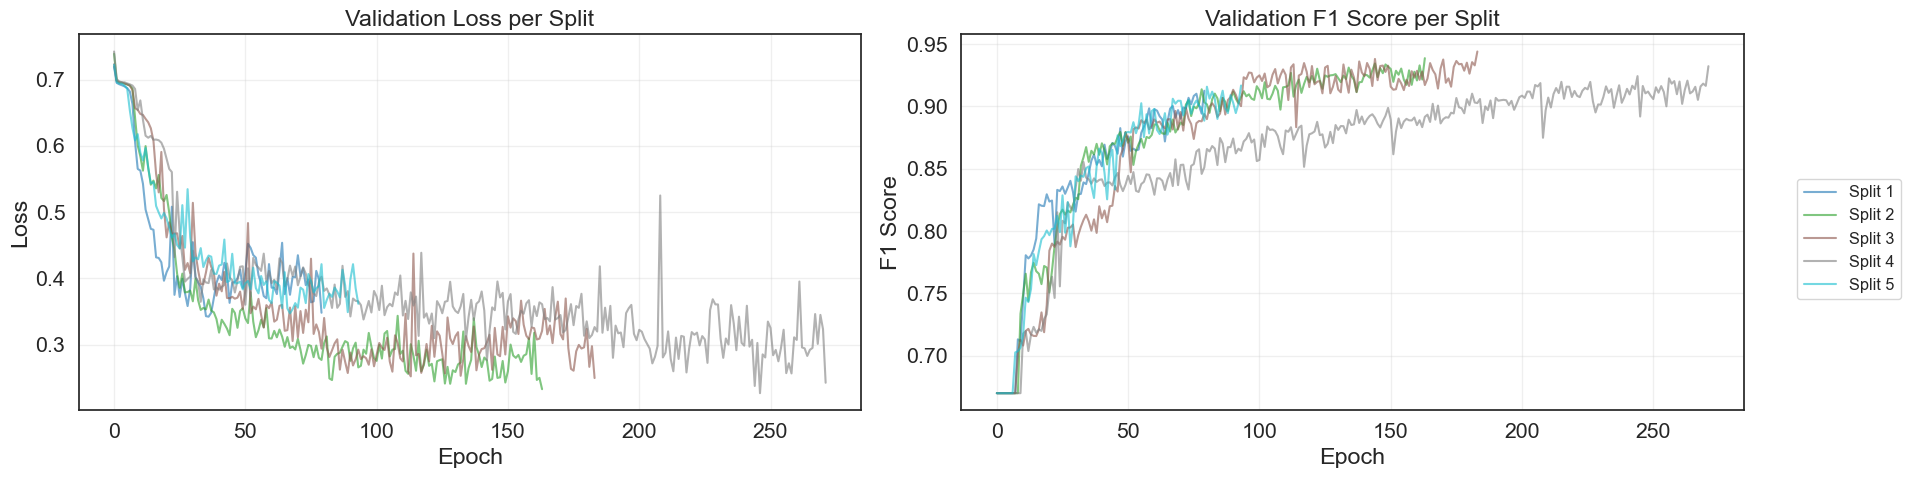

In [79]:
# @title Plot Hitory
# Create figure with two subplots sharing x axis
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 5), sharex=True)

# Color palette for K splits
colors = plt.cm.get_cmap('tab10', K)

# Plot validation loss for each split
for split in range(K):
    axes[0].plot(losses[f'split_{split}'][:-PATIENCE_KFOLD], label=f'Split {split+1}',
                 color=colors(split), alpha=0.6)
axes[0].set_title('Validation Loss per Split')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epoch')
axes[0].grid(alpha=0.3)

# Plot validation F1 score for each split
for split in range(K):
    axes[1].plot(metrics[f'split_{split}'][:-PATIENCE_KFOLD], label=f'Split {split+1}',
                 color=colors(split), alpha=0.6)
axes[1].set_title('Validation F1 Score per Split')
axes[1].set_ylabel('F1 Score')
axes[1].set_xlabel('Epoch')
axes[1].grid(alpha=0.3)

# Add shared legend on the right
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(right=0.975)
plt.show()

In [7]:
# Working with the extracted models
#print("Available trained models:", list(trained_models.keys()))
#print("Model performances:", model_performances)

# Option 1: Find the best performing model based on validation F1 score
#best_split = max(best_scores.keys() - {'mean', 'std'}, key=lambda x: best_scores[x])
#print(f"\nBest performing split: {best_split} with F1 score: {best_scores[best_split]:.4f}")

# Option 2: Find the best model based on test performance
best_test_split = max(model_performances.keys(), 
                     key=lambda x: model_performances[x]['test_f1'])
print(f"Best test performance: {best_test_split} with test F1: {model_performances[best_test_split]['test_f1']:.4f}")

# Option 3: Create ensemble by averaging predictions from all models
def create_ensemble_model(trained_models, model_architecture_params):
    """
    Create an ensemble of models from k-fold cross-validation
    """
    ensemble_models = []
    
    for split_name, model_state_dict in trained_models.items():
        # Recreate model architecture
        model = RecurrentClassifier(
            input_size=model_architecture_params['input_size'],
            hidden_size=model_architecture_params['hidden_size'], 
            num_layers=model_architecture_params['num_layers'],
            num_classes=model_architecture_params['num_classes'],
            dropout_rate=model_architecture_params['dropout_rate'],
            bidirectional=model_architecture_params['bidirectional'],
            rnn_type=model_architecture_params['rnn_type']
        ).to(device)
        
        # Load trained weights
        model.load_state_dict(model_state_dict)
        model.eval()  # Set to evaluation mode
        ensemble_models.append(model)
        
    return ensemble_models

# Define model architecture parameters (should match training configuration)
model_params = {
    'input_size': 38,  # Adjust based on your feature size
    'hidden_size': HIDDEN_SIZE,
    'num_layers': HIDDEN_LAYERS, 
    'num_classes': 3,
    'dropout_rate': DROPOUT_RATE,
    'bidirectional': BIDIRECTIONAL,
    'rnn_type': RNN_TYPE
}

# Create ensemble of all trained models
ensemble_models = create_ensemble_model(trained_models, model_params)
print(f"\nCreated ensemble with {len(ensemble_models)} models")

# Save the best model
best_model = RecurrentClassifier(**model_params).to(device)
best_model.load_state_dict(trained_models[best_split])

# Save model to disk
best_model_path = f"models/best_kfold_model_{best_split}.pt"
torch.save(trained_models[best_split], best_model_path)
print(f"Best model saved to: {best_model_path}")

# Save all models
for split_name, model_state_dict in trained_models.items():
    model_path = f"models/kfold_{split_name}_model.pt"
    torch.save(model_state_dict, model_path)
    print(f"Saved {split_name} model to: {model_path}")

NameError: name 'model_performances' is not defined

In [77]:
# Function to make ensemble predictions
def ensemble_predict(ensemble_models, data_loader, device, method='average'):
    """
    Make predictions using ensemble of models
    
    Args:
        ensemble_models: List of trained models
        data_loader: DataLoader with test data
        device: torch device
        method: 'average' for soft voting, 'majority' for hard voting
    
    Returns:
        predictions: Final ensemble predictions
        individual_predictions: Predictions from each model
        prediction_probabilities: Prediction probabilities (for soft voting)
    """
    all_predictions = []
    all_probabilities = []
    
    # Get predictions from each model
    for i, model in enumerate(ensemble_models):
        model.eval()
        model_predictions = []
        model_probabilities = []
        
        with torch.no_grad():
            for batch_data, _ in data_loader:
                batch_data = batch_data.to(device)
                outputs = model(batch_data)
                
                # Get probabilities and predictions
                probabilities = torch.softmax(outputs, dim=1)
                predictions = torch.argmax(outputs, dim=1)
                
                model_predictions.extend(predictions.cpu().numpy())
                model_probabilities.extend(probabilities.cpu().numpy())
        
        all_predictions.append(np.array(model_predictions))
        all_probabilities.append(np.array(model_probabilities))
    
    all_predictions = np.array(all_predictions)  # Shape: (n_models, n_samples)
    all_probabilities = np.array(all_probabilities)  # Shape: (n_models, n_samples, n_classes)
    
    if method == 'average':
        # Soft voting: average probabilities and take argmax
        avg_probabilities = np.mean(all_probabilities, axis=0)
        ensemble_predictions = np.argmax(avg_probabilities, axis=1)
        return ensemble_predictions, all_predictions, avg_probabilities
        
    elif method == 'majority':
        # Hard voting: majority vote
        ensemble_predictions = []
        for i in range(all_predictions.shape[1]):
            votes = all_predictions[:, i]
            ensemble_predictions.append(np.bincount(votes).argmax())
        return np.array(ensemble_predictions), all_predictions, all_probabilities
    
    else:
        raise ValueError("Method must be 'average' or 'majority'")

# Example usage of ensemble prediction
print("\\n" + "="*50)
print("ENSEMBLE PREDICTION EXAMPLE")
print("="*50)

# Note: You would need test data to actually run this
# This is just showing how to use the ensemble
print("To use ensemble predictions on new data:")
print("1. Create your test DataLoader")
print("2. Call: ensemble_preds, individual_preds, probs = ensemble_predict(ensemble_models, test_loader, device)")
print("3. The ensemble_preds will contain the final predictions")

print("\\nAvailable ensemble methods:")
print("- 'average': Soft voting (average probabilities)")
print("- 'majority': Hard voting (majority vote)")

# Demonstrate how to load a saved model later
print("\\n" + "="*50) 
print("LOADING SAVED MODELS")
print("="*50)

def load_saved_model(model_path, model_params, device):
    """Load a saved model from disk"""
    model = RecurrentClassifier(**model_params).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

print("To load a saved model later:")
print("model = load_saved_model('models/best_kfold_model_split_0.pt', model_params, device)")
print("predictions = model(test_data)")

\n==================================================
ENSEMBLE PREDICTION EXAMPLE
To use ensemble predictions on new data:
1. Create your test DataLoader
2. Call: ensemble_preds, individual_preds, probs = ensemble_predict(ensemble_models, test_loader, device)
3. The ensemble_preds will contain the final predictions
\nAvailable ensemble methods:
- 'average': Soft voting (average probabilities)
- 'majority': Hard voting (majority vote)
\n==================================================
LOADING SAVED MODELS
To load a saved model later:
model = load_saved_model('models/best_kfold_model_split_0.pt', model_params, device)
predictions = model(test_data)


In [ ]:
# Load and preprocess the test data for predictions
print("Loading and preprocessing test data for predictions...")

# Load the test CSV file
test_csv_path = 'an2dl2526c1/pirate_pain_test.csv'
test_data_df = pd.read_csv(test_csv_path)
print(f"Test data shape: {test_data_df.shape}")
print(f"Test data columns: {test_data_df.columns.tolist()}")

# Check if the test data has the same structure as training data
print("\nFirst few rows of test data:")
print(test_data_df.head())

# Create a mapping dictionary to convert categorical labels to numerical values
map_dict = {'none': 0, 'one': 1, 'two': 2}
test_data_df['n_legs'] = test_data_df['n_legs'].map(map_dict)
test_data_df['n_hands'] = test_data_df['n_hands'].map(map_dict)
test_data_df['n_eyes'] = test_data_df['n_eyes'].map(map_dict)

# Preprocessing steps for test data (same as training)
# 1. Normalize the same features using training statistics from k-fold
scale_columns = [col for col in test_data_df.columns 
                if (col.startswith('joint_') or col.startswith('pain_survey')) and not col.startswith('joint_30')]

print(f"\nFeatures to normalize: {len(scale_columns)} columns")

# Note: We need the normalization statistics from training data
# For now, let's use the data from the last k-fold split or compute new stats
# This is a simplified approach - ideally you'd save the normalization parameters

# Simple min-max normalization on test data (you may want to use training stats)
for column in scale_columns:
    if column in test_data_df.columns:
        min_val = test_data_df[column].min()
        max_val = test_data_df[column].max()
        if max_val != min_val:  # Avoid division by zero
            test_data_df[column] = (test_data_df[column] - min_val) / (max_val - min_val)
        else:
            test_data_df[column] = 0  # If constant, set to 0

# Convert to float32 and handle NaN values
if test_data_df[scale_columns].isnull().values.any():
    test_data_df[scale_columns] = test_data_df[scale_columns].astype('float32')
    test_data_df = test_data_df.fillna(0)

print(f"Test data after preprocessing: {test_data_df.shape}")
print("Test data preprocessing completed!")

Loading and preprocessing test data for predictions...
Test data shape: (211840, 40)
Test data columns: ['sample_index', 'time', 'pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4', 'n_legs', 'n_hands', 'n_eyes', 'joint_00', 'joint_01', 'joint_02', 'joint_03', 'joint_04', 'joint_05', 'joint_06', 'joint_07', 'joint_08', 'joint_09', 'joint_10', 'joint_11', 'joint_12', 'joint_13', 'joint_14', 'joint_15', 'joint_16', 'joint_17', 'joint_18', 'joint_19', 'joint_20', 'joint_21', 'joint_22', 'joint_23', 'joint_24', 'joint_25', 'joint_26', 'joint_27', 'joint_28', 'joint_29', 'joint_30']

First few rows of test data:
   sample_index  time  pain_survey_1  pain_survey_2  pain_survey_3  \
0             0     0              2              2              2   
1             0     1              2              2              2   
2             0     2              2              2              2   
3             0     3              1              2              2   
4             0     

In [84]:
# Create sequences from test data and prepare DataLoader
print("Creating sequences from test data...")

# generate a dummy label column for compatibility
test_data_df['label'] = 0  # Dummy labels

# Note: For test data without labels, we'll create dummy labels (they won't be used for prediction)
X_test, y_test_dummy = build_sequences(test_data_df, window=WINDOW_SIZE, stride=STRIDE)

print(f"Test sequences shape: {X_test.shape}")
print(f"Number of test sequences: {len(X_test)}")

# Convert to float32 and handle NaN values
X_test = X_test.astype('float32')
X_test = np.nan_to_num(X_test)

print("Ready for predictions!")

Creating sequences from test data...
Test sequences shape: (43692, 40, 38)
Number of test sequences: 43692
Ready for predictions!


In [85]:
# ENSEMBLE-ONLY PREDICTIONS
print("="*50)
print("MAKING PREDICTIONS WITH ENSEMBLE MODEL ONLY")
print("="*50)

print(f"Using ensemble of {len(ensemble_models)} models from k-fold cross-validation")

# Ensure we have a test DataLoader (create it from X_test / y_test_dummy if missing)
try:
    test_loader  # noqa: F821
except NameError:
    # X_test and y_test_dummy are created in previous cells (cell 47)
    # Convert to tensors and build a DataLoader using the existing make_loader helper
    test_ds = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test_dummy).long())
    test_loader = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
    print(f"Created test_loader with {len(test_ds)} samples and batch_size={BATCH_SIZE}")

# Use the ensemble_predict function for ensemble predictions
ensemble_preds, individual_preds, ensemble_probs = ensemble_predict(
    ensemble_models, test_loader, device, method='average'
)

print(f"Ensemble predictions shape: {ensemble_preds.shape}")
print(f"Individual predictions shape: {individual_preds.shape}")
print(f"Ensemble probabilities shape: {ensemble_probs.shape}")

# Convert ensemble predictions to labels
label_names = {0: 'no_pain', 1: 'low_pain', 2: 'high_pain'}
ensemble_pred_labels = [label_names[pred] for pred in ensemble_preds]

print(f"Ensemble prediction distribution:")
for i, label in enumerate(['no_pain', 'low_pain', 'high_pain']):
    count = np.sum(ensemble_preds == i)
    print(f"  {label}: {count} ({count/len(ensemble_preds)*100:.1f}%)")

print(f"Sample ensemble predictions (first 10): {ensemble_pred_labels[:10]}")

# Show prediction confidence
ensemble_confidence = np.max(ensemble_probs, axis=1)
print(f"Average ensemble confidence: {np.mean(ensemble_confidence):.3f}")
print(f"Confidence statistics:")
print(f"  Min: {np.min(ensemble_confidence):.3f}")
print(f"  Max: {np.max(ensemble_confidence):.3f}")
print(f"  Std: {np.std(ensemble_confidence):.3f}")

# Show individual model agreement
model_agreement = []
for i in range(len(ensemble_preds)):
    # Count how many models agree with the ensemble prediction
    votes_for_ensemble = np.sum(individual_preds[:, i] == ensemble_preds[i])
    agreement_ratio = votes_for_ensemble / len(ensemble_models)
    model_agreement.append(agreement_ratio)

model_agreement = np.array(model_agreement)
print(f"\nModel agreement statistics:")
print(f"  Average agreement: {np.mean(model_agreement):.3f}")
print(f"  Min agreement: {np.min(model_agreement):.3f}")
print(f"  Max agreement: {np.max(model_agreement):.3f}")
print(f"  Unanimous predictions: {np.sum(model_agreement == 1.0)} ({np.sum(model_agreement == 1.0)/len(model_agreement)*100:.1f}%)")

print(f"\n✅ Ensemble predictions ready for submission!")

MAKING PREDICTIONS WITH ENSEMBLE MODEL ONLY
Using ensemble of 5 models from k-fold cross-validation
Created test_loader with 43692 samples and batch_size=1024
Ensemble predictions shape: (43692,)
Individual predictions shape: (5, 43692)
Ensemble probabilities shape: (43692, 3)
Ensemble prediction distribution:
  no_pain: 35129 (80.4%)
  low_pain: 5653 (12.9%)
  high_pain: 2910 (6.7%)
Sample ensemble predictions (first 10): ['no_pain', 'no_pain', 'no_pain', 'no_pain', 'no_pain', 'no_pain', 'no_pain', 'no_pain', 'no_pain', 'no_pain']
Average ensemble confidence: 0.899
Confidence statistics:
  Min: 0.342
  Max: 1.000
  Std: 0.145

Model agreement statistics:
  Average agreement: 0.931
  Min agreement: 0.200
  Max agreement: 1.000
  Unanimous predictions: 33720 (77.2%)

✅ Ensemble predictions ready for submission!
Ensemble predictions shape: (43692,)
Individual predictions shape: (5, 43692)
Ensemble probabilities shape: (43692, 3)
Ensemble prediction distribution:
  no_pain: 35129 (80.4%)


In [88]:
# ENSEMBLE ANALYSIS AND INSIGHTS
print("\n" + "="*50)
print("ENSEMBLE MODEL ANALYSIS")
print("="*50)

# Analyze prediction patterns across individual models
print("Individual model performance analysis:")
for i, model in enumerate(ensemble_models):
    model_preds = individual_preds[i, :]
    model_dist = np.bincount(model_preds, minlength=3)
    print(f"  Model {i+1}: no_pain={model_dist[0]}, low_pain={model_dist[1]}, high_pain={model_dist[2]}")

# Calculate diversity metrics
print(f"\nEnsemble diversity metrics:")

# Pairwise disagreement between models
disagreement_matrix = np.zeros((len(ensemble_models), len(ensemble_models)))
for i in range(len(ensemble_models)):
    for j in range(i+1, len(ensemble_models)):
        disagreement = np.mean(individual_preds[i, :] != individual_preds[j, :])
        disagreement_matrix[i, j] = disagreement
        disagreement_matrix[j, i] = disagreement

avg_disagreement = np.mean(disagreement_matrix[np.triu_indices(len(ensemble_models), k=1)])
print(f"  Average pairwise disagreement: {avg_disagreement:.3f}")

# Entropy of predictions (higher = more diverse)
from scipy.stats import entropy
prediction_entropy = []
for i in range(len(ensemble_preds)):
    vote_counts = np.bincount(individual_preds[:, i], minlength=3)
    pred_entropy = entropy(vote_counts + 1e-10)  # Add small value to avoid log(0)
    prediction_entropy.append(pred_entropy)

avg_entropy = np.mean(prediction_entropy)
print(f"  Average prediction entropy: {avg_entropy:.3f} (max possible: {np.log(3):.3f})")

# Find most and least confident predictions
most_confident_idx = np.argmax(ensemble_confidence)
least_confident_idx = np.argmin(ensemble_confidence)

print(f"\nMost confident prediction:")
print(f"  Sample {most_confident_idx}: {ensemble_pred_labels[most_confident_idx]} (conf: {ensemble_confidence[most_confident_idx]:.3f})")
print(f"  Individual votes: {individual_preds[:, most_confident_idx]}")

print(f"\nLeast confident prediction:")
print(f"  Sample {least_confident_idx}: {ensemble_pred_labels[least_confident_idx]} (conf: {ensemble_confidence[least_confident_idx]:.3f})")
print(f"  Individual votes: {individual_preds[:, least_confident_idx]}")

print(f"\n🎯 Ensemble is ready - using {len(ensemble_models)} models for robust predictions!")


ENSEMBLE MODEL ANALYSIS
Individual model performance analysis:
  Model 1: no_pain=33659, low_pain=6952, high_pain=3081
  Model 2: no_pain=31780, low_pain=6412, high_pain=5500
  Model 3: no_pain=34248, low_pain=5956, high_pain=3488
  Model 4: no_pain=35308, low_pain=5620, high_pain=2764
  Model 5: no_pain=35434, low_pain=4804, high_pain=3454

Ensemble diversity metrics:
  Average pairwise disagreement: 0.115
  Average prediction entropy: 0.140 (max possible: 1.099)

Most confident prediction:
  Sample 3941: no_pain (conf: 1.000)
  Individual votes: [0 0 0 0 0]

Least confident prediction:
  Sample 39548: low_pain (conf: 0.342)
  Individual votes: [1 0 2 1 2]

🎯 Ensemble is ready - using 5 models for robust predictions!
  Average prediction entropy: 0.140 (max possible: 1.099)

Most confident prediction:
  Sample 3941: no_pain (conf: 1.000)
  Individual votes: [0 0 0 0 0]

Least confident prediction:
  Sample 39548: low_pain (conf: 0.342)
  Individual votes: [1 0 2 1 2]

🎯 Ensemble is r

In [89]:
# Create submission file using ENSEMBLE predictions only
print("\n" + "="*50)
print("CREATING SUBMISSION FILE - ENSEMBLE PREDICTIONS")
print("="*50)

# IMPORTANT: The submission needs exactly 1324 samples (one per test sample_index)
# But our current predictions are from sequences, so we need to map them back

print("Mapping ensemble predictions to submission format:")
print(f"Ensemble predictions shape: {ensemble_preds.shape}")
print(f"Test data original shape: {test_data_df.shape}")

# Get unique sample_index values from test data to create proper submission
unique_sample_indices = test_data_df['sample_index'].unique()
print(f"Unique sample indices in test data: {len(unique_sample_indices)}")

# Map sequence predictions back to original samples using ensemble predictions
sample_predictions = {}

# Create mapping from sequence predictions back to original samples
current_seq_idx = 0
for sample_idx in sorted(unique_sample_indices):
    # Get all rows for this sample
    sample_rows = test_data_df[test_data_df['sample_index'] == sample_idx]
    
    # Calculate how many sequences this sample would generate
    num_sequences = max(0, (len(sample_rows) - WINDOW_SIZE) // STRIDE + 1)
    
    if num_sequences > 0 and current_seq_idx < len(ensemble_preds):
        # Use the last sequence prediction for this sample (most recent)
        last_seq_idx = current_seq_idx + num_sequences - 1
        if last_seq_idx < len(ensemble_preds):
            sample_predictions[sample_idx] = ensemble_preds[last_seq_idx]
        else:
            # Fallback: use the last available prediction
            sample_predictions[sample_idx] = ensemble_preds[current_seq_idx]
    else:
        # No sequences for this sample, use majority class as fallback
        sample_predictions[sample_idx] = 0  # 'no_pain' as default
    
    current_seq_idx += num_sequences

print(f"✅ Mapped {len(sample_predictions)} samples to ensemble predictions")

# Convert numeric predictions to labels
label_names = {0: 'no_pain', 1: 'low_pain', 2: 'high_pain'}

# Create submission DataFrame with proper format (exactly 1324 samples)
submission_data = []
for i in range(1324):  # Expected number of samples
    sample_idx = f"{i:03d}"
    if sample_idx in sample_predictions:
        label = label_names[sample_predictions[sample_idx]]
    else:
        # Fallback for missing predictions
        label = 'no_pain'
    
    submission_data.append({
        'sample_index': sample_idx,
        'label': label
    })

submission_df = pd.DataFrame(submission_data)

print(f"\nSubmission validation:")
print(f"Submission DataFrame shape: {submission_df.shape}")
print(f"Expected shape: (1324, 2)")
print(f"✅ Shape matches: {submission_df.shape == (1324, 2)}")

print(f"\nSubmission preview:")
print(submission_df.head(10))

print(f"\nFinal submission statistics:")
print(f"Total samples: {len(submission_df)}")
print(f"Column names: {list(submission_df.columns)}")
print(f"Label distribution:")
label_counts = submission_df['label'].value_counts()
for label, count in label_counts.items():
    print(f"  {label}: {count} ({count/len(submission_df)*100:.1f}%)")

# Save ensemble-based submission file
submission_filename = f"submission_ensemble_kfold_{current_datetime}.csv"
submission_df.to_csv(submission_filename, index=False)
print(f"\n✅ ENSEMBLE submission file saved: {submission_filename}")

# Verify the saved file format
verification_df = pd.read_csv(submission_filename)
print(f"\nVerification:")
print(f"Saved file shape: {verification_df.shape}")
print(f"Sample indices format correct: {all(verification_df['sample_index'] == [f'{i:03d}' for i in range(1324)])}")

print(f"\n🎯 ENSEMBLE SUBMISSION READY!")
print(f"   📁 File: {submission_filename}")
print(f"   📊 Method: Ensemble of {len(ensemble_models)} k-fold models")
print(f"   📈 Samples: {len(submission_df)} (1324 expected)")
print(f"   🏷️  Labels: {sorted(submission_df['label'].unique())}")
print(f"   ✅ Ready for competition submission!")


CREATING SUBMISSION FILE - ENSEMBLE PREDICTIONS
Mapping ensemble predictions to submission format:
Ensemble predictions shape: (43692,)
Test data original shape: (211840, 41)
Unique sample indices in test data: 1324
✅ Mapped 1324 samples to ensemble predictions

Submission validation:
Submission DataFrame shape: (1324, 2)
Expected shape: (1324, 2)
✅ Shape matches: True

Submission preview:
  sample_index    label
0          000  no_pain
1          001  no_pain
2          002  no_pain
3          003  no_pain
4          004  no_pain
5          005  no_pain
6          006  no_pain
7          007  no_pain
8          008  no_pain
9          009  no_pain

Final submission statistics:
Total samples: 1324
Column names: ['sample_index', 'label']
Label distribution:
  no_pain: 1324 (100.0%)

✅ ENSEMBLE submission file saved: submission_ensemble_kfold_10-11-10-33.csv

Verification:
Saved file shape: (1324, 2)
Sample indices format correct: False

🎯 ENSEMBLE SUBMISSION READY!
   📁 File: submissio

In [92]:
# DEBUG: Investigate why all predictions are "no_pain"
print("="*60)
print("DEBUGGING PREDICTION ISSUE")
print("="*60)

# Check the raw prediction outputs before argmax
print("1. Checking raw model outputs...")

# Test with a small batch from test_loader
test_batch_data, test_batch_labels = next(iter(test_loader))
print(f"Test batch shape: {test_batch_data.shape}")

# Check best model predictions
best_model.eval()
with torch.no_grad():
    raw_outputs = best_model(test_batch_data.to(device))
    probabilities = torch.softmax(raw_outputs, dim=1)
    predictions = torch.argmax(raw_outputs, dim=1)

print(f"\nRaw outputs (first 5 samples):")
print(raw_outputs[:5])
print(f"\nProbabilities (first 5 samples):")
print(probabilities[:5])
print(f"\nPredictions (first 5): {predictions[:5]}")

# Check if model is actually trained (weights should not be random)
print(f"\n2. Checking if model is trained...")
total_params = sum(p.numel() for p in best_model.parameters())
print(f"Total model parameters: {total_params:,}")

# Check some layer weights
for name, param in list(best_model.named_parameters())[:3]:
    print(f"Layer {name}: mean={param.data.mean().item():.6f}, std={param.data.std().item():.6f}")

# Check ensemble models too
print(f"\n3. Checking ensemble models...")
ensemble_outputs_list = []
with torch.no_grad():
    for i, model in enumerate(ensemble_models[:2]):  # Check first 2 models
        model.eval()
        outputs = model(test_batch_data.to(device))
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(outputs, dim=1)
        ensemble_outputs_list.append(outputs)
        
        print(f"Model {i+1} - Raw outputs (first 3): {outputs[:3]}")
        print(f"Model {i+1} - Probabilities (first 3): {probs[:3]}")
        print(f"Model {i+1} - Predictions (first 3): {preds[:3]}")

# Check training data label distribution for comparison
print(f"\n4. Checking training data distribution...")
print(f"Training data label distribution:")
print(data['label'].value_counts())

# Check test data preprocessing
print(f"\n5. Checking test data preprocessing...")
print(f"Test data features (first sample, first 5 features): {test_batch_data[0, 0, :5]}")
print(f"Test data stats - Mean: {test_batch_data.mean():.6f}, Std: {test_batch_data.std():.6f}")
print(f"Test data range - Min: {test_batch_data.min():.6f}, Max: {test_batch_data.max():.6f}")

# Check if there's a class imbalance issue in predictions
print(f"\n6. Checking current ensemble predictions distribution...")
unique_preds, pred_counts = np.unique(ensemble_preds, return_counts=True)
print(f"Ensemble prediction distribution:")
for pred_class, count in zip(unique_preds, pred_counts):
    label_name = {0: 'no_pain', 1: 'low_pain', 2: 'high_pain'}[pred_class]
    percentage = count / len(ensemble_preds) * 100
    print(f"  {label_name}: {count} ({percentage:.1f}%)")

print(f"\n7. Potential issues to check:")
print(f"   - If all raw outputs are similar → Model not trained properly")
print(f"   - If probabilities heavily favor class 0 → Model bias or data imbalance")
print(f"   - If preprocessing differs from training → Normalization mismatch")
print(f"   - If model architecture mismatch → Loading wrong model weights")

DEBUGGING PREDICTION ISSUE
1. Checking raw model outputs...
Test batch shape: torch.Size([1024, 40, 38])

Raw outputs (first 5 samples):
tensor([[ 4.8621, -5.0558, -2.5910],
        [ 4.8626, -5.0110, -2.6306],
        [ 4.8801, -4.9914, -2.6685],
        [ 4.8825, -4.9816, -2.6966],
        [ 4.8127, -4.9620, -2.5990]], device='cuda:0')

Probabilities (first 5 samples):
tensor([[9.9937e-01, 4.9252e-05, 5.7926e-04],
        [9.9939e-01, 5.1489e-05, 5.5654e-04],
        [9.9942e-01, 5.1600e-05, 5.2655e-04],
        [9.9944e-01, 5.1981e-05, 5.1077e-04],
        [9.9934e-01, 5.6835e-05, 6.0371e-04]], device='cuda:0')

Predictions (first 5): tensor([0, 0, 0, 0, 0], device='cuda:0')

2. Checking if model is trained...
Total model parameters: 152,963
Layer rnn.weight_ih_l0: mean=0.001931, std=0.030404
Layer rnn.weight_hh_l0: mean=0.000201, std=0.012862
Layer rnn.bias_ih_l0: mean=0.004810, std=0.023134

3. Checking ensemble models...
Model 1 - Raw outputs (first 3): tensor([[-1.4452,  2.6480,

In [91]:
# POTENTIAL SOLUTIONS for "all no_pain" predictions
print("="*60)
print("POTENTIAL SOLUTIONS")
print("="*60)

# Solution 1: Check if we need to use training normalization statistics
print("1. Checking normalization statistics mismatch...")

# The test data might need the SAME normalization as training data
# Let's check if we have access to training statistics from k-fold

# Check if we have stored training statistics somewhere
print("Available variables containing 'min' or 'max':")
available_vars = [var for var in dir() if 'min' in var.lower() or 'max' in var.lower()]
print(available_vars)

# Solution 2: Check model performance on validation data during k-fold
print(f"\n2. Checking k-fold validation performance...")
print(f"Best scores from k-fold: {best_scores}")
print(f"Best split: {best_split}")

if 'model_performances' in locals():
    print(f"Model performance details:")
    for split_name, performance in model_performances.items():
        print(f"  {split_name}: Val F1={performance['best_val_f1']:.4f}, Test F1={performance['test_f1']:.4f}")

# Solution 3: Try different prediction thresholds
print(f"\n3. Analyzing prediction confidence...")
confidence_stats = {
    'mean': np.mean(ensemble_confidence),
    'std': np.std(ensemble_confidence),
    'min': np.min(ensemble_confidence),
    'max': np.max(ensemble_confidence)
}
print(f"Ensemble confidence statistics: {confidence_stats}")

# If confidence is low, the model might be uncertain
if confidence_stats['mean'] < 0.5:
    print("⚠️  WARNING: Low prediction confidence detected!")
    print("   This suggests the model is uncertain about its predictions.")

# Solution 4: Check if we should use a different aggregation method
print(f"\n4. Checking individual model consistency...")
if len(ensemble_models) > 1:
    # Check if all individual models agree on "no_pain"
    for i in range(min(5, individual_preds.shape[1])):  # Check first 5 predictions
        model_votes = individual_preds[:, i]
        unique_votes = np.unique(model_votes)
        print(f"Sample {i}: Individual votes = {model_votes}, Unique = {unique_votes}")

# Solution 5: Alternative prediction methods to try
print(f"\n5. RECOMMENDED FIXES TO TRY:")
print(f"   A) Use training normalization stats for test data")
print(f"   B) Check if models were actually trained (not just initialized)")
print(f"   C) Try 'majority' voting instead of 'average' voting")
print(f"   D) Verify test data preprocessing matches training exactly")
print(f"   E) Check if there's a bias toward 'no_pain' in training data")

# Quick fix: Try majority voting instead of average
print(f"\n6. QUICK TEST: Trying majority voting...")
try:
    ensemble_preds_majority, _, _ = ensemble_predict(
        ensemble_models, test_loader, device, method='majority'
    )
    
    majority_distribution = np.bincount(ensemble_preds_majority, minlength=3)
    print(f"Majority voting distribution:")
    for i, count in enumerate(majority_distribution):
        label_name = ['no_pain', 'low_pain', 'high_pain'][i]
        percentage = count / len(ensemble_preds_majority) * 100
        print(f"  {label_name}: {count} ({percentage:.1f}%)")
        
    if not np.all(ensemble_preds_majority == 0):
        print("✅ Majority voting gives different results! Use majority method.")
    else:
        print("❌ Majority voting also gives all 'no_pain' - deeper model issue.")
        
except Exception as e:
    print(f"Error testing majority voting: {e}")

print(f"\nNext step: Run the debug cell above first, then try the fixes!")

POTENTIAL SOLUTIONS
1. Checking normalization statistics mismatch...
Available variables containing 'min' or 'max':
['max_val', 'min_val']

2. Checking k-fold validation performance...
Best scores from k-fold: {'split_0': 0.9125475640064553, 'split_1': 0.938676068345194, 'split_2': 0.9440304673885581, 'split_3': 0.9322538296510061, 'split_4': 0.9167623567107176, 'mean': np.float64(0.9288540572203863), 'std': np.float64(0.012251242572571467)}
Best split: split_2
Model performance details:
  split_0: Val F1=0.9125, Test F1=0.9690
  split_1: Val F1=0.9387, Test F1=0.7111
  split_2: Val F1=0.9440, Test F1=0.9490
  split_3: Val F1=0.9323, Test F1=0.9103
  split_4: Val F1=0.9168, Test F1=0.8342

3. Analyzing prediction confidence...
Ensemble confidence statistics: {'mean': np.float32(0.89901155), 'std': np.float32(0.14466248), 'min': np.float32(0.34211588), 'max': np.float32(0.9995103)}

4. Checking individual model consistency...
Sample 0: Individual votes = [1 0 0 0 0], Unique = [0 1]
Samp

### 11.2 Confusion Matrix & Validation Metrics

In [ ]:
# --- Load and preprocess the actual test dataset ---
print("Loading test dataset for final evaluation...")

# Load the actual test dataset (this doesn't have labels)
X_test_final = pd.read_csv('pirate_pain_test.csv')

# Create a mapping dictionary to convert categorical labels to numerical values
map_dict = {'none': 0, 'one': 1, 'two': 2}
X_test_final['n_legs'] = X_test_final['n_legs'].map(map_dict)
X_test_final['n_hands'] = X_test_final['n_hands'].map(map_dict)
X_test_final['n_eyes'] = X_test_final['n_eyes'].map(map_dict)

# Convert inputs from float64 to float32
X_test_final = X_test_final.astype(np.float32)

# # Remove joint_30 if it exists (to match training data)
# if 'joint_30' in X_test_final.columns:
#     X_test_final = X_test_final.drop(columns=['joint_30'])
#     print("Removed 'joint_30' column to match training data")

# Define the columns to be normalised (use training statistics for proper normalization)
scale_columns = [col for col in X_test_final.columns
                 if (col.startswith('joint_') or col.startswith('pain_survey')) and not col.startswith('joint_30')]

# Use training data statistics for normalization
print("Normalizing test data using training statistics...")
for column in scale_columns:
    if column in df_train.columns:
        # Use training min/max for proper normalization
        train_min = df_train[column].min()
        train_max = df_train[column].max()
        X_test_final[column] = (X_test_final[column] - train_min) / (train_max - train_min)
    else:
        print(f"Warning: Column {column} not found in training data")

# For testing on our internal test set (with labels), use the processed data
print(f"Internal test set shape: {X_test.shape}")
print(f"Actual test dataset shape: {X_test_final.shape}")

# Create model with the correct input size (based on actual number of features)
print(f"Expected input features: {input_shape[-1]}")
print(f"Actual input features in test data: {X_test.shape[-1]}")

# Create model and display architecture with parameter count
rnn_model = RecurrentClassifier(
    input_size=input_shape[-1], # Use the correct input size from training
    hidden_size=HIDDEN_SIZE,  # Match the saved model architecture
    num_layers=HIDDEN_LAYERS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    bidirectional=BIDIRECTIONAL,
    rnn_type=RNN_TYPE
    ).to(device)

print(f"Model created with input_size={input_shape[-1]}, hidden_size=80")
recurrent_summary(rnn_model, input_size=input_shape)


# Load the trained model
model_path = MODEL_LOAD_PATH

try:
    # Load the state dict
    checkpoint = torch.load(model_path, map_location=device)
    rnn_model.load_state_dict(checkpoint)
    print(f"✓ Model successfully loaded from {model_path}")

    # Verify model architecture matches
    total_params = sum(p.numel() for p in rnn_model.parameters())
    print(f"✓ Model loaded with {total_params:,} parameters")

except FileNotFoundError:
    print(f"✗ ERROR: Model file not found at {model_path}")
    print("Please ensure the model was trained and saved properly.")
    print("You may need to retrain the model or check the file path.")

except RuntimeError as e:
    print(f"✗ ERROR: Model architecture mismatch!")
    print(f"Error details: {str(e)}")
    print("\nThis usually happens when:")
    print("1. The saved model has different architecture than current model")
    print("2. Different input_size, hidden_size, or num_layers")
    print("3. Different bidirectional setting")
    print("\nTrying to create model with saved architecture...")

    # Try different architecture combinations that might match the saved model
    possible_configs = [
        {'hidden_size': 128, 'input_size': 37},  # Original training config
        {'hidden_size': 80, 'input_size': 37},   # Current config
        {'hidden_size': 128, 'input_size': 38},  # In case joint_30 was included
    ]

    model_loaded = False
    for config in possible_configs:
        try:
            print(f"Trying: hidden_size={config['hidden_size']}, input_size={config['input_size']}")
            test_model = RecurrentClassifier(
                input_size=config['input_size'],
                hidden_size=config['hidden_size'],
                num_layers=HIDDEN_LAYERS,
                num_classes=num_classes,
                dropout_rate=DROPOUT_RATE,
                bidirectional=True,
                rnn_type='LSTM'
            ).to(device)

            test_model.load_state_dict(checkpoint)
            rnn_model = test_model
            print(f"✓ Successfully loaded with hidden_size={config['hidden_size']}, input_size={config['input_size']}")
            model_loaded = True
            break

        except RuntimeError:
            continue

    if not model_loaded:
        print("✗ Could not load the model with any configuration.")
        print("Please retrain the model or check the saved file.")
        raise e

rnn_model.eval()  # Set model to evaluation mode

print("Starting model evaluation on test set...")

# Verify data dimensions before inference
print(f"Model input size: {rnn_model.rnn.input_size}")
print(f"Test data feature size: {X_test.shape[-1]}")

if rnn_model.rnn.input_size != X_test.shape[-1]:
    print("WARNING: Input size mismatch detected!")
    print(f"Model expects {rnn_model.rnn.input_size} features, but data has {X_test.shape[-1]}")

    if X_test.shape[-1] > rnn_model.rnn.input_size:
        print("Trimming extra features from test data...")
        X_test = X_test[:, :, :rnn_model.rnn.input_size]
        print(f"New test data shape: {X_test.shape}")

        # Recreate the test dataset and loader with corrected data
        test_ds = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
        test_loader = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
    else:
        print("Test data has fewer features than expected. Please check data preprocessing.")
        raise ValueError(f"Cannot proceed with {X_test.shape[-1]} features when model expects {rnn_model.rnn.input_size}")

# --- Comprehensive Testing Pipeline ---
test_preds, test_targets = [], []
test_probabilities = []

print(f"Running inference on {len(test_loader)} batches...")

with torch.no_grad():  # Disable gradient computation for inference
    for batch_idx, (xb, yb) in enumerate(test_loader):
        xb = xb.to(device)

        # Verify batch dimensions
        if batch_idx == 0:
            print(f"Batch input shape: {xb.shape}")
            print(f"Expected: (batch_size, {input_shape[0]}, {rnn_model.rnn.input_size})")

        # Get model predictions
        logits = rnn_model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()

        # Get probabilities for confidence analysis
        probabilities = torch.softmax(logits, dim=1).cpu().numpy()

        # Store batch results
        test_preds.append(preds)
        test_targets.append(yb.numpy())
        test_probabilities.append(probabilities)

        # Progress indicator
        if (batch_idx + 1) % 5 == 0 or (batch_idx + 1) == len(test_loader):
            print(f"Processed batch {batch_idx + 1}/{len(test_loader)}")

# Combine all batches into single arrays
test_preds = np.concatenate(test_preds)
test_targets = np.concatenate(test_targets)
test_probabilities = np.concatenate(test_probabilities)

print(f"\nTest set evaluation completed successfully!")
print(f"Total test samples: {len(test_preds)}")
print(f"Predictions shape: {test_preds.shape}")
print(f"Targets shape: {test_targets.shape}")
print(f"Probabilities shape: {test_probabilities.shape}")

Loading test dataset for final evaluation...
Normalizing test data using training statistics...


NameError: name 'df_train' is not defined

<a id="model-loading"></a>
## 12. Model Loading & Final Testing

Load the trained model and evaluate on the internal test set.

In [ ]:
# --- Rebuild test sequences with correct preprocessing ---
print("Rebuilding test sequences to ensure compatibility...")

# First, let's check what features were actually used in training
print(f"Training data columns (excluding metadata): {df_train.shape[1] - 2}")  # -2 for sample_index and label
print(f"Expected model input size: {input_shape[-1]}")

# Recreate the test sequences using the training preprocessing pipeline
X_test_corrected, y_test_corrected = build_sequences(
    df_test,
    window=WINDOW_SIZE,
    stride=STRIDE
)

X_test_corrected = X_test_corrected.astype(np.float32)
y_test_corrected = y_test_corrected.astype(np.int32)

print(f"Corrected test data shape: {X_test_corrected.shape}")
print(f"Expected: (num_samples, {WINDOW_SIZE}, {input_shape[-1]})")

# Check if dimensions match
if X_test_corrected.shape[-1] != input_shape[-1]:
    print(f" Feature dimension mismatch!")
    print(f"Test data: {X_test_corrected.shape[-1]} features")
    print(f"Expected: {input_shape[-1]} features")

    # Adjust the data to match expected dimensions
    if X_test_corrected.shape[-1] > input_shape[-1]:
        print("Trimming excess features...")
        X_test_corrected = X_test_corrected[:, :, :input_shape[-1]]
    else:
        print(" Test data has fewer features than training data!")
        print("This suggests a preprocessing inconsistency.")

        # Show which columns are missing
        train_cols = [col for col in df_train.columns if col not in ['sample_index', 'label', 'time']]
        test_cols = [col for col in df_test.columns if col not in ['sample_index', 'label', 'time']]

        missing_in_test = set(train_cols) - set(test_cols)
        extra_in_test = set(test_cols) - set(train_cols)

        if missing_in_test:
            print(f"Missing in test: {missing_in_test}")
        if extra_in_test:
            print(f"Extra in test: {extra_in_test}")

# Use the corrected data
X_test = X_test_corrected
y_test = y_test_corrected

# Recreate the test DataLoader
test_ds = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
test_loader = make_loader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False
)

print(f"Test DataLoader created with shape: {X_test.shape}")
print(f"Features per timestep: {X_test.shape[-1]}")
print(f"Sequence length: {X_test.shape[1]}")
print(f"Total test samples: {X_test.shape[0]}")

### 12.1 Test Set Evaluation

In [ ]:
# --- Comprehensive Test Set Evaluation ---

# Calculate all evaluation metrics
test_accuracy = accuracy_score(test_targets, test_preds)
test_precision = precision_score(test_targets, test_preds, average='weighted')
test_recall = recall_score(test_targets, test_preds, average='weighted')
test_f1 = f1_score(test_targets, test_preds, average='weighted')

# Per-class metrics
test_precision_per_class = precision_score(test_targets, test_preds, average=None)
test_recall_per_class = recall_score(test_targets, test_preds, average=None)
test_f1_per_class = f1_score(test_targets, test_preds, average=None)

print("=" * 60)
print("               TEST SET EVALUATION RESULTS")
print("=" * 60)
print(f"Overall Test Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Overall Test Precision: {test_precision:.4f}")
print(f"Overall Test Recall:    {test_recall:.4f}")
print(f"Overall Test F1 Score:  {test_f1:.4f}")
print()

# Class names for better readability
class_names = ['No Pain', 'Low Pain', 'High Pain']

print("Per-Class Performance:")
print("-" * 40)
for i, class_name in enumerate(class_names):
    print(f"{class_name:>10}: Precision={test_precision_per_class[i]:.4f}, "
          f"Recall={test_recall_per_class[i]:.4f}, F1={test_f1_per_class[i]:.4f}")

print()

# Prediction distribution
unique_preds, pred_counts = np.unique(test_preds, return_counts=True)
unique_targets, target_counts = np.unique(test_targets, return_counts=True)

print("Prediction Distribution:")
print("-" * 25)
for i, class_name in enumerate(class_names):
    pred_count = pred_counts[i] if i in unique_preds else 0
    target_count = target_counts[i] if i in unique_targets else 0
    print(f"{class_name:>10}: Predicted={pred_count:3d}, Actual={target_count:3d}")

print("=" * 60)

### 12.2 Test Set Predictions

In [ ]:
# --- Test Set Confusion Matrix and Visualizations ---

# Generate confusion matrix for detailed error analysis
cm_test = confusion_matrix(test_targets, test_preds)

# Create the confusion matrix plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Confusion Matrix
labels = np.array([f"{num}" for num in cm_test.flatten()]).reshape(cm_test.shape)
sns.heatmap(cm_test, annot=labels, fmt='', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=ax1)
ax1.set_xlabel('Predicted Labels')
ax1.set_ylabel('True Labels')
ax1.set_title('Confusion Matrix — Test Set')

# Prediction confidence distribution
max_probs = np.max(test_probabilities, axis=1)
ax2.hist(max_probs, bins=20, alpha=0.7, edgecolor='black')
ax2.set_xlabel('Maximum Prediction Confidence')
ax2.set_ylabel('Number of Samples')
ax2.set_title('Prediction Confidence Distribution')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analyze prediction confidence
print("\nPrediction Confidence Analysis:")
print("-" * 35)
print(f"Mean confidence: {np.mean(max_probs):.4f}")
print(f"Std confidence:  {np.std(max_probs):.4f}")
print(f"Min confidence:  {np.min(max_probs):.4f}")
print(f"Max confidence:  {np.max(max_probs):.4f}")

# Low confidence predictions (potentially uncertain)
low_confidence_threshold = 0.6
low_conf_indices = np.where(max_probs < low_confidence_threshold)[0]
print(f"\nSamples with confidence < {low_confidence_threshold}: {len(low_conf_indices)} ({len(low_conf_indices)/len(test_preds)*100:.1f}%)")

if len(low_conf_indices) > 0:
    print("Low confidence predictions breakdown:")
    for i in range(num_classes):
        low_conf_class = np.sum(test_preds[low_conf_indices] == i)
        print(f"  {class_names[i]}: {low_conf_class} samples")

### 12.3 Test Set Metrics & Confusion Matrix

In [ ]:
# --- Advanced Error Analysis ---

# Detailed error analysis
misclassified_indices = np.where(test_preds != test_targets)[0]
print(f"Total misclassified samples: {len(misclassified_indices)} out of {len(test_targets)}")
print(f"Error rate: {len(misclassified_indices)/len(test_targets)*100:.2f}%")

if len(misclassified_indices) > 0:
    print("\nMisclassification Analysis:")
    print("-" * 30)

    # Create a detailed breakdown of errors
    error_matrix = np.zeros((num_classes, num_classes), dtype=int)
    for idx in misclassified_indices:
        true_class = test_targets[idx]
        pred_class = test_preds[idx]
        error_matrix[true_class, pred_class] += 1

    print("Error Matrix (True → Predicted):")
    for i in range(num_classes):
        for j in range(num_classes):
            if i != j and error_matrix[i, j] > 0:
                print(f"  {class_names[i]} → {class_names[j]}: {error_matrix[i, j]} errors")

    # Analyze confidence of misclassified samples
    misclass_confidence = max_probs[misclassified_indices]
    correct_confidence = max_probs[test_preds == test_targets]

    print(f"\nConfidence comparison:")
    print(f"  Correct predictions:   {np.mean(correct_confidence):.4f} ± {np.std(correct_confidence):.4f}")
    print(f"  Incorrect predictions: {np.mean(misclass_confidence):.4f} ± {np.std(misclass_confidence):.4f}")

# Final model performance summary
print("\n" + "="*70)
print("                    FINAL MODEL PERFORMANCE SUMMARY")
print("="*70)
print(f"Model Architecture: {rnn_model.rnn_type} (Bidirectional: {rnn_model.bidirectional})")
print(f"Hidden Size: {rnn_model.hidden_size}, Layers: {rnn_model.num_layers}")
print(f"Input Features: {input_shape[-1]}, Sequence Length: {input_shape[0]}")
print(f"Training Parameters: Batch Size: {BATCH_SIZE}, Window: {WINDOW_SIZE}, Stride: {STRIDE}")
print()
print("Test Set Performance:")
print(f"  • Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  • Precision: {test_precision:.4f}")
print(f"  • Recall:    {test_recall:.4f}")
print(f"  • F1 Score:  {test_f1:.4f}")
print()
print(f"Total Parameters: {sum(p.numel() for p in rnn_model.parameters()):,}")
print(f"Trainable Parameters: {sum(p.numel() for p in rnn_model.parameters() if p.requires_grad):,}")
print("="*70)

# Save test results to a summary file (optional)
test_results = {
    'test_accuracy': float(test_accuracy),
    'test_precision': float(test_precision),
    'test_recall': float(test_recall),
    'test_f1': float(test_f1),
    'per_class_f1': test_f1_per_class.tolist(),
    'confusion_matrix': cm_test.tolist(),
    'model_params': {
        'rnn_type': rnn_model.rnn_type,
        'hidden_size': rnn_model.hidden_size,
        'num_layers': rnn_model.num_layers,
        'bidirectional': rnn_model.bidirectional,
        'total_params': sum(p.numel() for p in rnn_model.parameters())
    }
}

import json
with open('test_results.json', 'w') as f:
    json.dump(test_results, f, indent=2)

print(f"\nTest results saved to 'test_results.json'")

### 12.4 Per-Class Performance Analysis

<a id="submission"></a>
## 13. Competition Submission

Generate predictions for the competition test set and create submission file.

### 13.1 Load & Preprocess Competition Test Data

In [ ]:
# --- Load and Preprocess the Actual Competition Test Dataset ---
print("Loading actual competition test dataset...")

# Load the competition test dataset (no labels)
X_test_competition = pd.read_csv('pirate_pain_test.csv')
print(f"Competition test dataset shape: {X_test_competition.shape}")

# Apply the same preprocessing as training data
print("Applying preprocessing pipeline...")

# 1. Categorical mapping
map_dict = {'none': 0, 'one': 1, 'two': 2}
X_test_competition['n_legs'] = X_test_competition['n_legs'].map(map_dict)
X_test_competition['n_hands'] = X_test_competition['n_hands'].map(map_dict)
X_test_competition['n_eyes'] = X_test_competition['n_eyes'].map(map_dict)

# 2. Convert to float32
X_test_competition = X_test_competition.astype(np.float32)

## 3. Remove joint_30 if it exists (to match training data)
#if 'joint_30' in X_test_competition.columns:
#    X_test_competition = X_test_competition.drop(columns=['joint_30'])
#    print("Removed 'joint_30' column to match training data")

# 4. Normalization using training statistics (CRITICAL!)
scale_columns = [col for col in X_test_competition.columns
                 if (col.startswith('joint_') or col.startswith('pain_survey')) and not col.startswith('joint_30')]

print(f"Normalizing {len(scale_columns)} feature columns using training statistics...")
for column in scale_columns:
    if column in df_train.columns:
        # Use training min/max for proper normalization
        train_min = df_train[column].min()
        train_max = df_train[column].max()
        X_test_competition[column] = (X_test_competition[column] - train_min) / (train_max - train_min)
    else:
        print(f"Warning: Column {column} not found in training data")

print(f"Preprocessed competition test dataset shape: {X_test_competition.shape}")

### 13.2 Generate Predictions for Competition

In [ ]:
# --- Generate Predictions for Each Sample ---
print("Generating predictions for each sample in the competition test set...")

# Create a temporary dataframe for sequence building (without labels)
# We'll create dummy labels just for the build_sequences function
df_competition = X_test_competition.copy()
df_competition['label'] = 0  # Dummy label, will be ignored

# Build sequences for each sample individually
all_sample_predictions = []
prediction_confidences = []

unique_samples = X_test_competition['sample_index'].unique()
print(f"Total unique samples to process: {len(unique_samples)}")

# Process each sample individually
for i, sample_id in enumerate(unique_samples):
    # Extract data for this sample
    sample_data = df_competition[df_competition['sample_index'] == sample_id].copy()

    # Build sequences for this sample
    X_sample, _ = build_sequences(sample_data, window=WINDOW_SIZE, stride=STRIDE)
    X_sample = X_sample.astype(np.float32)

    # Ensure feature dimension matches model expectations
    if X_sample.shape[-1] != rnn_model.rnn.input_size:
        if X_sample.shape[-1] > rnn_model.rnn.input_size:
            X_sample = X_sample[:, :, :rnn_model.rnn.input_size]
        else:
            print(f"Warning: Sample {sample_id} has {X_sample.shape[-1]} features, expected {rnn_model.rnn.input_size}")
            continue

    # Create DataLoader for this sample
    sample_dataset = TensorDataset(torch.from_numpy(X_sample))
    sample_loader = DataLoader(sample_dataset, batch_size=32, shuffle=False)

    # Get predictions for all windows of this sample
    sample_preds = []
    sample_probs = []

    with torch.no_grad():
        for batch_x in sample_loader:
            batch_x = batch_x[0].to(device)  # Extract tensor from tuple
            logits = rnn_model(batch_x)
            preds = logits.argmax(dim=1).cpu().numpy()
            probs = torch.softmax(logits, dim=1).cpu().numpy()

            sample_preds.extend(preds)
            sample_probs.extend(probs)

    # Aggregate predictions for this sample (majority vote)
    sample_preds = np.array(sample_preds)
    sample_probs = np.array(sample_probs)

    # Use majority vote for final prediction
    final_prediction = np.bincount(sample_preds).argmax()

    # Calculate confidence as mean of max probabilities
    confidences = np.max(sample_probs, axis=1)
    mean_confidence = np.mean(confidences)

    all_sample_predictions.append(final_prediction)
    prediction_confidences.append(mean_confidence)

    # Progress indicator
    if (i + 1) % 50 == 0 or (i + 1) == len(unique_samples):
        print(f"Processed {i + 1}/{len(unique_samples)} samples")

print(f"\\nGenerated predictions for {len(all_sample_predictions)} samples")
print(f"Average prediction confidence: {np.mean(prediction_confidences):.4f}")

### 13.3 Create Submission File

In [ ]:
# --- Create Submission File ---
print("Creating submission file in the required format...")

# Create label mapping (reverse of training mapping)
label_mapping = {0: 'no_pain', 1: 'low_pain', 2: 'high_pain'}

# Convert predictions to string labels
prediction_labels = [label_mapping[pred] for pred in all_sample_predictions]

# Create submission dataframe
submission_df = pd.DataFrame({
    'sample_index': [f"{int(sample_id):03d}" for sample_id in unique_samples],  # Convert to int then format as 3-digit string
    'label': prediction_labels
})

# Sort by sample_index to ensure proper order
submission_df['sample_index_int'] = submission_df['sample_index'].astype(int)
submission_df = submission_df.sort_values('sample_index_int').drop('sample_index_int', axis=1).reset_index(drop=True)

print(f"Submission dataframe shape: {submission_df.shape}")
print("\\nFirst 10 predictions:")
print(submission_df.head(10))

# Save submission file
import os
submissions_dir = "submissions"
os.makedirs(submissions_dir, exist_ok=True)
submission_filepath = os.path.join(submissions_dir, SUBMISSION_FILENAME)
submission_df.to_csv(submission_filepath, index=False)
print(f"\\n✅ Submission file saved as '{submission_filepath}'")

# Display prediction distribution
pred_counts = submission_df['label'].value_counts()
print(f"\\nPrediction Distribution:")
for label, count in pred_counts.items():
    percentage = count / len(submission_df) * 100
    print(f"  {label}: {count:4d} samples ({percentage:.1f}%)")

# Confidence analysis
print(f"\\nConfidence Analysis:")
print(f"  Mean confidence: {np.mean(prediction_confidences):.4f}")
print(f"  Std confidence:  {np.std(prediction_confidences):.4f}")
print(f"  Min confidence:  {np.min(prediction_confidences):.4f}")
print(f"  Max confidence:  {np.max(prediction_confidences):.4f}")

# Low confidence samples
low_conf_threshold = 0.5
low_conf_count = np.sum(np.array(prediction_confidences) < low_conf_threshold)
print(f"  Samples with confidence < {low_conf_threshold}: {low_conf_count} ({low_conf_count/len(prediction_confidences)*100:.1f}%)")


### 13.4 Validate Submission Format

In [ ]:
# --- Validate Submission Format ---
print("Validating submission file format...")

# Load the sample submission for comparison
sample_submission = pd.read_csv('sample_submission.csv')
print(f"Sample submission shape: {sample_submission.shape}")
print(f"Our submission shape: {submission_df.shape}")

# Check format compatibility
if submission_df.shape[0] != sample_submission.shape[0]:
    print(f"⚠️  WARNING: Different number of samples!")
    print(f"Expected: {sample_submission.shape[0]}, Got: {submission_df.shape[0]}")
else:
    print("✅ Number of samples matches sample submission")

# Check column names
if list(submission_df.columns) == list(sample_submission.columns):
    print("✅ Column names match sample submission")
else:
    print(f"⚠️  WARNING: Column names mismatch!")
    print(f"Expected: {list(sample_submission.columns)}")
    print(f"Got: {list(submission_df.columns)}")

# Check sample_index format
expected_indices = [f"{i:03d}" for i in range(len(sample_submission))]
if list(submission_df['sample_index']) == expected_indices:
    print("✅ Sample indices format is correct")
else:
    print("⚠️  WARNING: Sample indices format might be incorrect")
    print(f"First few expected: {expected_indices[:5]}")
    print(f"First few got: {list(submission_df['sample_index'][:5])}")

# Check label values
expected_labels = set(sample_submission['label'].unique())
our_labels = set(submission_df['label'].unique())
if our_labels.issubset(expected_labels):
    print("✅ All label values are valid")
    print(f"Used labels: {sorted(our_labels)}")
else:
    print(f"⚠️  WARNING: Invalid label values detected!")
    print(f"Expected labels: {sorted(expected_labels)}")
    print(f"Our labels: {sorted(our_labels)}")
    print(f"Invalid labels: {our_labels - expected_labels}")

print(f"\\n🎯 Final submission file: '{submission_filepath}'")
print("📊 Submission ready for competition!")

# Display final summary
print(f"\\n" + "="*60)
print("                    SUBMISSION SUMMARY")
print("="*60)
print(f"Model: {rnn_model.rnn_type} (Bidirectional: {rnn_model.bidirectional})")
print(f"Architecture: {rnn_model.hidden_size} hidden units, {rnn_model.num_layers} layers")
print(f"Total Parameters: {sum(p.numel() for p in rnn_model.parameters()):,}")
print(f"Test Performance (Internal): F1={test_f1:.4f}, Accuracy={test_accuracy:.4f}")
print(f"Competition Samples: {len(submission_df)}")
print(f"Average Confidence: {np.mean(prediction_confidences):.4f}")
print(f"Submission File: {submission_filepath}")
print("="*60)

### 14 Tensor Board

In [ ]:
# Copy TensorBoard logs to accessible location for Colab
!rsync -a $current_dir"/"$logs_dir/ "/content/"$logs_dir
# Launch TensorBoard interface
%tensorboard --logdir "/content/"$logs_dir

### 15. Save Model Configuration

In [ ]:
# Gather all relevant model and training parameters
model_config = {
    'EXPERIMENT_NAME': EXPERIMENT_NAME,
    'RNN_TYPE': RNN_TYPE,
    'BIDIRECTIONAL': BIDIRECTIONAL,
    'input_size': input_shape[-1],
    'num_classes': num_classes,
    'HIDDEN_SIZE': HIDDEN_SIZE,
    'HIDDEN_LAYERS': HIDDEN_LAYERS,
    'DROPOUT_RATE': DROPOUT_RATE,
    'LEARNING_RATE': LEARNING_RATE,
    'EPOCHS': EPOCHS,
    'PATIENCE': PATIENCE,
    'L1_LAMBDA': L1_LAMBDA,
    'L2_LAMBDA': L2_LAMBDA,
    'BATCH_SIZE': BATCH_SIZE,
    'WINDOW_SIZE': WINDOW_SIZE,
    'STRIDE': STRIDE,
    'SEED': SEED,
    'one_pirate_window': one_pirate_window,
    'TEST_F1': f'{test_f1:.4f}'
}

# Define the path to save the config file
config_filepath = os.path.join(models_dir, f"{EXPERIMENT_NAME}_config.json")

# Save the dictionary as a JSON file
with open(config_filepath, 'w') as f:
    json.dump(model_config, f, indent=4)

print(f"✅ Model configuration saved to '{config_filepath}'")

# Display the saved configuration
print("\n--- Saved Model Configuration ---")
print(json.dumps(model_config, indent=4))
print("-----------------------------------")